In [1]:
import numpy as np
from gekko import GEKKO
from scipy.integrate import RK45, odeint, solve_ivp
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [19]:
# Initial conditions

state0 = [0,0,1000,100,100,0]
# Time steps and size
dt = 0.01
tf = 10 # final time
# Other paremeters
e = 0.8 # coeff of restitution
g = -680

In [20]:
# Define velocity and position functions
def f(t, v):
    return [v[3],v[4], v[5], 0, 0, g]
def hit_ground(t, y):
    return y[2]-90
hit_ground.terminal = True
hit_ground.direction = -1


1.6359922335498105
4.253579807229507
6.3476498661732625
8.022905913328266
9.36311075105227
10.0


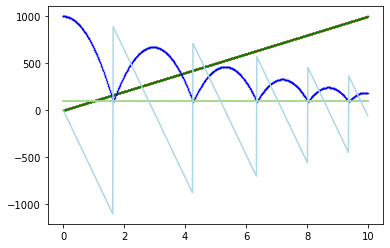

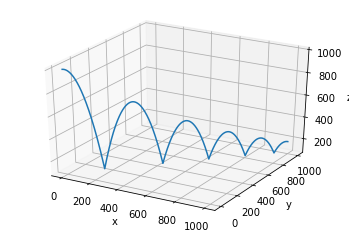

In [21]:
# empty trajectory vectors
t = np.empty((0))
state = np.empty((6,0))
sn = state0
tn = 0 # interation time to restart solution at new time
tf = 10 # final time

# In a loop calculate until system hits terminal
# Append data to trajectory vectors
# Invert velocity and scale by e
# repeat until t[-1] >= tf

while(True):
    sol = solve_ivp(f, [tn, tf], sn, events = hit_ground, max_step = dt)
    # append
    t = np.append(t, sol.t[:-2])
    state = np.append(state, sol.y[:,:-2], axis=1)
    # update next iteration values
    tn = sol.t[-1]
    sn = sol.y[:,-1]
    sn[5] *= -1*e
    
    print(sol.t[-1])
    # check if at tf
    if(sol.t[-1] >= tf):
        break
    

# plot
plt.figure()
plt.plot(t, state[0], 'r.', markersize=1)
plt.plot(t, state[1], 'g.', markersize=1)
plt.plot(t, state[2], 'b.', markersize=1)
plt.plot(t, state[3], 'lightcoral', markersize=1)
plt.plot(t, state[4], 'lightgreen', markersize=1)
plt.plot(t, state[5], 'lightblue', markersize=1)

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, state[0], state[1], state[2])

In [22]:
class BallTrajectory:
    def __init__(self, t, state):
        self.t = t
        self.pos = state[0:3]
        self.vel = state[3:6]
    

In [23]:
ball_traj = BallTrajectory(t, state)
ball_traj.pos.shape

(3, 1001)

In [43]:
# Car initial state (only driving)
s0 = [0,0,0]
v0 = [0,0,0]
yaw0 = 0
yaw_dot0=0
opt = GEKKO(remote=False)

# Set solver options
opt.options.NODES=3
opt.options.SOLVER=3
opt.options.IMODE=6
opt.options.MAX_ITER=800
opt.options.MV_TYPE=0
opt.options.DIAGLEVEL=0

# Set solver hyper parameters----------
# number of discretizations
n = 51

# end time variables to multiply u2 by to get total value of integral
# Time vector length is nt1 and nt2
p_d = np.zeros(n)
p_d[-1] = 1.0
final = opt.Param(value = p_d)

# MVs
a = opt.MV(fixed_initial=False, lb=0, ub=1000)
a.STATUS=1
steer = opt.MV(fixed_initial=False,lb=-1, ub=1)
steer.STATUS=1

# Parameters-----------------
r = opt.Param(value=90) # radius of ball
g = opt.Param(value=-680) # gravity acceleration

# Variables----------------
# times
opt.time = np.linspace(0,1,n)
tf = opt.FV(value=10, lb=1, ub=100, name='tf')
tf.STATUS = 0

solver_time = opt.Var(value=0)
opt.Equation(solver_time.dt()/tf == 1)


#state variables
bs = opt.Array(opt.Var, (3)) # ball position
for ind, b in enumerate(bs):
    b.value = ball_traj.pos[ind,0]
bv = opt.Array(opt.Var, (3)) # ball velocity
for ind, b in enumerate(bv):
    b.value = ball_traj.vel[ind,0]
x = opt.Var(value=s0[0], name='x')
y = opt.Var(value=s0[1], name='y')
vx = opt.Var(value=v0[0], name='vx')
vy = opt.Var(value=v0[1], name='vy')
yaw = opt.Var(value=yaw0, lb=-np.pi, ub=np.pi, name='yaw')
yaw_dot = opt.Var(value=yaw_dot0, name='yaw_dot')
v_mag = opt.Var(value = np.sqrt(v0[0]**2 + v0[1]**2), ub=2300)


# c-spline of ball trajectory
for index, i in enumerate(bs):
    opt.cspline(solver_time,i,ball_traj.t, ball_traj.pos[index])
for index, i in enumerate(bv):
    opt.cspline(solver_time, i, ball_traj.t, ball_traj.vel[index])

# c-spline for curvature
cur = np.array([0.0069, 0.00398, 0.00235, 0.001375, 0.0011, 0.00088])
v_cur = np.array([0,500,1000,1500,1750,2300])
v_cur_fine = np.linspace(0,2300,100)
cur_fine = np.interp(v_cur_fine, v_cur, cur)
curvature = opt.Var(name='curvature')
opt.cspline(v_mag, curvature, v_cur_fine, cur_fine)
    
# equations
opt.Equation(x.dt()/tf == vx*opt.cos(yaw))
opt.Equation(y.dt()/tf == vy*opt.sin(yaw))
opt.Equation(vx.dt()/tf == a*opt.cos(yaw))
opt.Equation(vy.dt()/tf == a*opt.sin(yaw))
opt.Equation(v_mag**2 == vx**2 + vy**2)
opt.Equation(yaw.dt()/tf == yaw_dot)
opt.Equation(yaw_dot == (steer) * curvature * v_mag)

# objective functions
opt.Minimize((bs[0] - x)**2)
opt.Minimize((bs[1] - y)**2)

# solve
opt.solve(disp=True)


 ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  7
   Constants    :  0
   Variables    :  21
   Intermediates:  0
   Connections  :  16
   Equations    :  10
   Residuals    :  10
 
 Number of state variables:    2702
 Number of total equations: -  2600
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    102
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
   

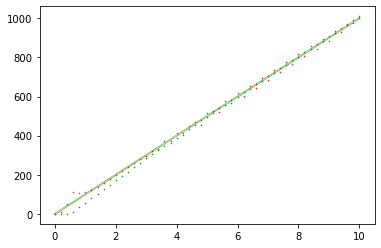

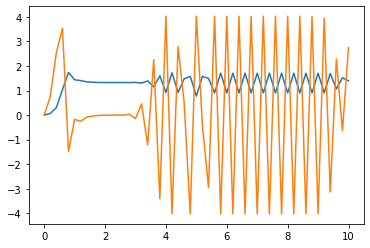

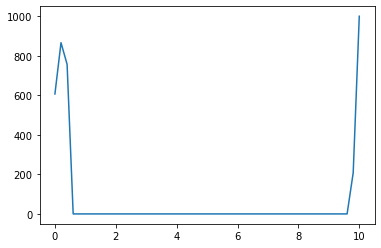

In [44]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(opt.time*tf, bs[0].value, 'darkred')
plt.plot(opt.time*tf, bs[1].value, 'lightgreen')
plt.plot(opt.time*tf, x.value, 'r.', markersize=1)
plt.plot(opt.time*tf, y.value, 'g.', markersize=1)

plt.figure(2)
plt.plot(opt.time*tf, yaw.value)
plt.plot(opt.time*tf, yaw_dot.value)
plt.figure(3)
plt.plot(opt.time*tf, a.value)

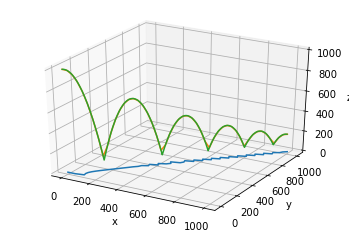

In [45]:
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, x.value, y.value)
Axes3D.plot(ax, bs[0].value, bs[1].value, bs[2].value)
Axes3D.plot(ax, state[0], state[1], state[2])